In [1]:
import os
import nltk
import random
import string
import pandas as pd
import codecs 
import pprint
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import math
import gensim
import seaborn as sns

from xml.etree.ElementTree import parse
from lxml import etree
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from nltk import bigrams
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from nltk.corpus import wordnet

data_path = '../Data'

### Loading Data

In [2]:
ngram_range = (2,3) 

In [3]:
#Extract relevant information and put into dictionary.
#For this xml file, I only have data up till 2017
with codecs.open(os.path.join(data_path, 'wsdm.xml'), 'r', encoding = 'UTF_8') as f:
    xml_string = f.read()

# Parse the XML data
root = ET.fromstring(xml_string) # xml_data is the variable that contains your XML data as a string

# Iterate over the hit elements
doc = {}
for i, hit in enumerate(root.findall('hits/hit')):
    # Get the hit id attribute
    hit_id = hit.get('id')
    # Get the title element text
    title = hit.find('info/title').text
    # Get the year element text
    year = hit.find('info/year').text
    # Print the hit id and title
    #print(f'Hit ID: {hit_id}, Title: {title}, Year: {year}')
    
    if year not in doc.keys():
        doc[year] = [title]
    else:
        doc[year].append(title)

for key in doc.keys():
    print(f"Year: {key}, documents: {doc[key]}")

# doc['2023']

Year: 2023, documents: ['AI Decision Systems with Feedback Loop Active Learner.', 'Utilising Crowdsourcing to Assess the Effectiveness of Item-based Explanations of Merchant Recommendations.', 'The Determination of the Learning Performance based on Assessment Item Analysis.', 'WSDM Cup 2023 Challenge on Visual Question Answering.', 'To Aggregate or Not? Learning with Separate Noisy Labels.', 'Recent Advances on Deep Learning based Knowledge Tracing.', 'Incorporating Fairness in Large Scale NLU Systems.', 'DeMEtRIS: Counting (near)-Cliques by Crawling.', 'Towards an Event-Aware Urban Mobility Prediction System.', 'A Tutorial on Domain Generalization.', 'Scalable Adversarial Attack Algorithms on Influence Maximization.', 'Knowledge-Augmented Methods for Natural Language Processing.', 'Self-Supervised Graph Structure Refinement for Graph Neural Networks.', 'AgAsk: A Conversational Search Agent for Answering Agricultural Questions.', 'Dependency-aware Self-training for Entity Alignment.', 

In [4]:
# Check how many title in each year
for year in doc.keys():
    print(f'There are {len(doc[year])} documents in {year}')

There are 194 documents in 2023
There are 211 documents in 2022
There are 181 documents in 2021
There are 151 documents in 2020
There are 128 documents in 2019
There are 116 documents in 2018
There are 19 documents in 2017


### Cleaning Data
- Case folding
- Remove tokens comprising of only punctuations
- Remove numebers
- Lemmatization
- Stopwords are removed during vectorization

In [5]:
def lemmatize_with_pos(sentences):
    # Tokenize and perform POS tagging for each sentence
    pos_tags_list = [pos_tag(word_tokenize(sentence)) for sentence in sentences]
    
    # Map NLTK POS tags to WordNet POS tags
    tag_map = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    
    # Initialize the WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each word based on its POS tag and concatenate into a single list
    lemmatized_tokens = []
    for pos_tags in pos_tags_list:
        lemmatized_tokens+=[lemmatizer.lemmatize(word, tag_map.get(pos[0], 'n')) for word, pos in pos_tags]
    
    return lemmatized_tokens

# Initializations
pre_processed_doc = {} 
lemmatizer = WordNetLemmatizer()       
#Create a table for removal of punctuations
table = str.maketrans('', '', string.punctuation)

for key in doc.keys():
    for i, document in enumerate(doc[key]):
        token = word_tokenize(document)     
        token = [word.lower() for word in token]        
#         token = [word for word in token if word not in stop_words] # Stopword removal will be handled in vectorizer
        token = [w.translate(table) for w in token]         # Removal of punctuations
        token = [word for word in token if word != ("")]      # Remove blanks
        token = [word for word in token if not word.isnumeric()]        #Remove numbers
        token = lemmatize_with_pos(token)  #Do this last
        token = ' '.join(token)
        if key not in pre_processed_doc.keys():
            pre_processed_doc[key] = [token]
        else:
            pre_processed_doc[key].append(token)

In [6]:
msg = ['testing', 'is', 'are', 'networks', 'towards']
lemmatize_with_pos(msg)

['test', 'be', 'be', 'network', 'towards']

In [7]:
pre_processed_doc['2018']

['on the power of massive text data',
 'multidimensional network embed with hierarchical structure',
 'performance analysis of a privacy constrain knn recommendation use data sketch',
 'can you trust the trend discover simpson s paradox in social data',
 'influence maximization in online social network',
 'a discrete choice model for subset selection',
 'latent cross make use of context in recurrent recommender system',
 'a call to arm embrace assistive ai system',
 'consistent transformation of ratio metric for efficient online control experiment',
 'neural graph learn training neural network use graph',
 'sketch em all fast approximate similarity search for dynamic data stream',
 'fast coresetbased diversity maximization under matroid constraint',
 'put data in the driver s seat optimize earnings for ondemand ridehailing',
 'connectivity in complex network measure inference and optimization',
 'wsdm cup music recommendation and churn prediction',
 'sequential recommendation with user

### Get tfidf, idf, term freq, doc freq

In [8]:
def get_scores(doc, ngram_range, stopwords):
    '''
    Creates a dataframe consisting of the tfidf, idf, term freq and doc freq for respective tokens
    '''
    # Create count vectorizer for term frequency
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords)
    count_matrix = count_vectorizer.fit_transform(doc)
    feature_names = count_vectorizer.get_feature_names_out()
    term_frequency = count_matrix.toarray().sum(axis=0)  # Sum along columns and flatten
    # Create a DataFrame to store the results of term frequency
    count_data = {
        'Token': feature_names,
        'Term_Frequency': term_frequency}
    count_df = pd.DataFrame(count_data)

    
    # Create TfidfVectorizer
    tfidf = TfidfVectorizer(ngram_range=ngram_range, stop_words=stopwords)
    tfidf_matrix = tfidf.fit_transform(doc) 
    feature_names = tfidf.get_feature_names_out()

    # Get TFIDF, IDF, doc frequency scores
    tfidf_values = tfidf_matrix.toarray()
    # Calculate document frequency (DF) for each token
    document_frequency = (tfidf_matrix > 0).sum(axis=0).A1
    # IDF scores
    idf_scores = tfidf.idf_

    # Create a DataFrame to store the results
    tfidf_data = {
        'Token': feature_names,
        'TFIDF_score': tfidf_values.sum(axis=0),
        'IDF_score': idf_scores,
        'Doc_freq': document_frequency
    }
    
    tfidf_df = pd.DataFrame(tfidf_data)
    
    
    return pd.merge(tfidf_df, count_df, how = 'left', on = 'Token')

### Define stopwords

In [9]:
# Define stopwords
stopword_1 = stopwords.words('english')
stopword_2 = list(gensim.parsing.preprocessing.STOPWORDS)
stopword_3 = []
manual_stopwords = set(stopword_1 + stopword_2 + stopword_3)  

### Plot wordcloud

In [10]:
# Creates a dictionary of score_df. Key is which year it came from
score_dict = {}
'''
'key1': [df1, df2]
'''
for key in pre_processed_doc.keys():
    score_df = get_scores(pre_processed_doc[key], stopwords = manual_stopwords, ngram_range = ngram_range)
    if key in score_dict.keys():
        # In case there are duplicates of the same year
        score_dict[key].append(score_df)
        print(f'Year {key} has an additional document appended')
    else:
        score_dict[key] = [score_df]

In [11]:
score_dict['2018'][0].head()

,Token,TFIDF_score,IDF_score,Doc_freq,Term_Frequency
0,5th international,0.200617,5.069027,1,1
1,5th international workshop,0.200617,5.069027,1,1
2,ab test,0.447214,5.069027,1,1
3,ab test recommender,0.447214,5.069027,1,1
4,accelerate distribute,0.309521,5.069027,1,1


In [12]:
def plot_top_bar_indi(df, top_n, sort_col, x, y):
    '''
    df: document
    top_n: top n tokens to be displayed
    sort_col: sort by which column
    x: var to be plotted on the x axis
    y: var to be plotted on the y axis
    '''
    df.sort_values([sort_col], ascending = False, inplace = True)
    df = df.head(top_n)
    
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sns.barplot(x=x, y=y, data=df, palette='viridis')
    plt.xticks(rotation=45);

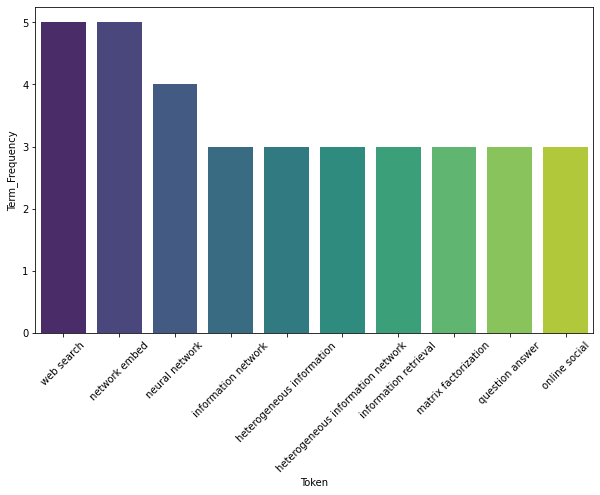

In [13]:
df = score_dict['2018'][0]
top_n = 10
y = 'Term_Frequency'
x = 'Token'
sort_col = 'Term_Frequency'

plot_top_bar_indi(df, top_n, sort_col, x, y)

In [14]:
def plot_top_bar(doc, col_num, top_n, x, y):
    '''
    doc: document
    col_num: # Col to plot in final plot
    top_n: top n tokens to be displayed
    x: var to be plotted on the x axis
    y: var to be plotted on the y axis
    sort_col: sort by which column
    '''
    nrows, ncols = math.ceil(len(doc)/col_num), col_num
    fig, axs = plt.subplots(nrows, ncols, figsize=(10 * 2, 5 * nrows))
    sort_col = y

    yr_ls = list(doc.keys())
    for i in range(len(doc)):
        yr = yr_ls[i]
        df = doc[yr][0]
        df.sort_values([sort_col], ascending = False, inplace = True)
        df = df.head(top_n)

        sns.barplot(x=x, y=y, data=df, palette='viridis', ax=axs[i // ncols, i % ncols])
        axs[i //ncols, i%ncols].set_xticklabels(axs[i // ncols, i % ncols].get_xticklabels(), rotation=45)
        axs[i//ncols , i%ncols].set_title(f"Barplot of top {top_n} tokens for year {yr} using {y}")
        axs[i // ncols, i % ncols].set_xlabel('')

    plt.subplots_adjust(hspace=1)

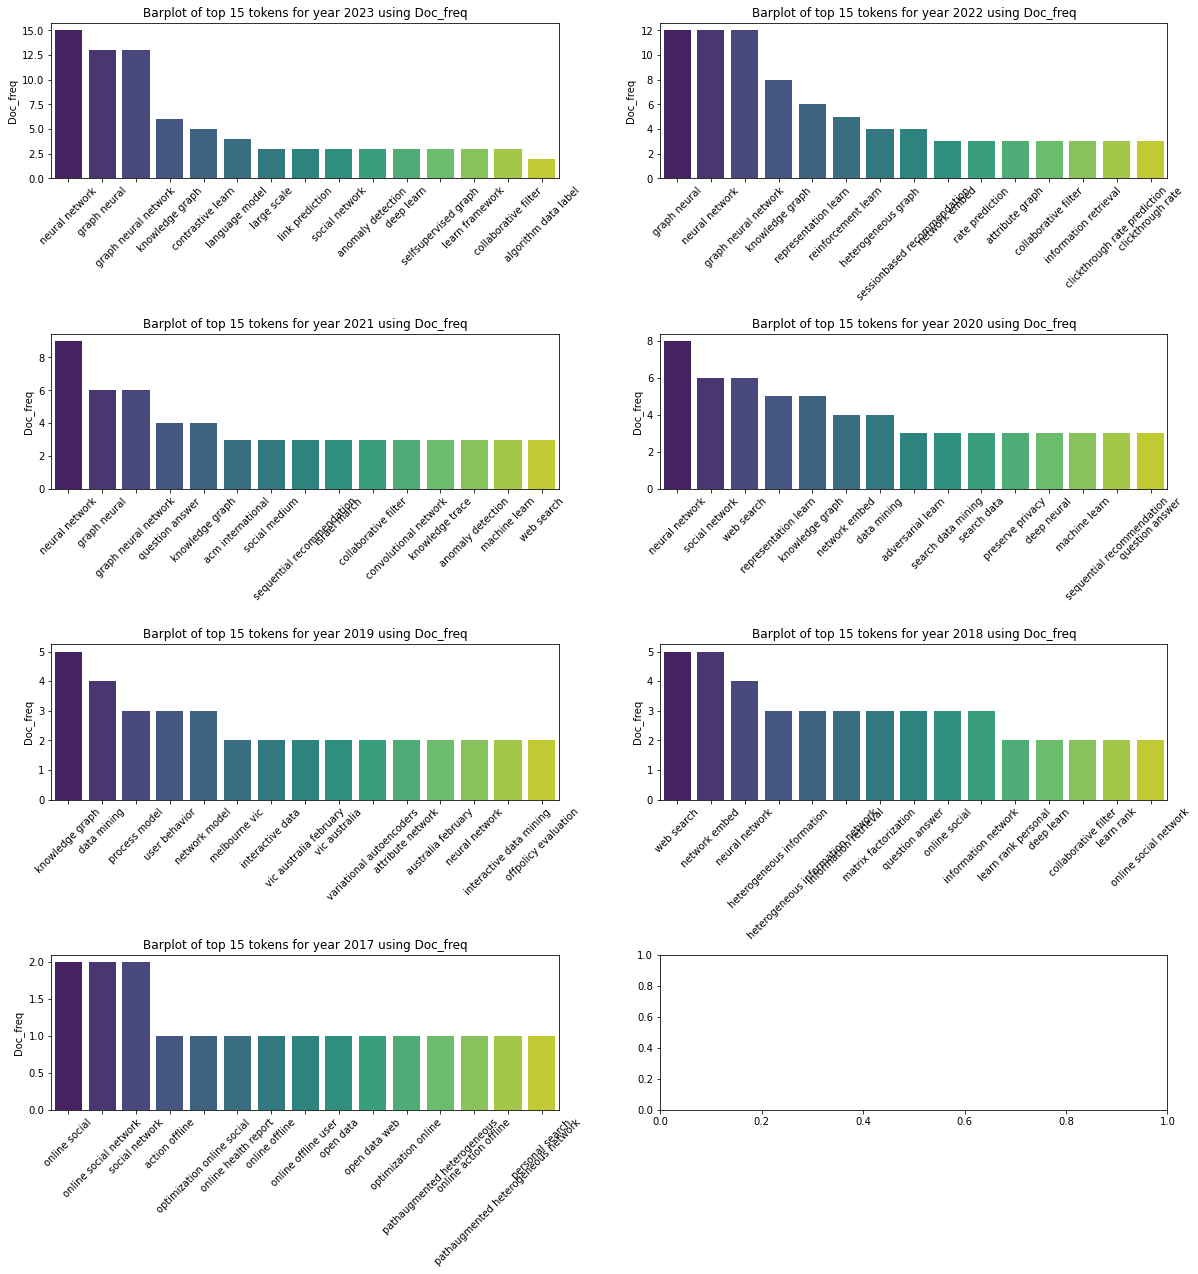

In [15]:
col_num = 2
doc = score_dict
top_n = 15
y = 'Doc_freq'
x = 'Token'

plot_top_bar(doc, col_num, top_n, x, y)

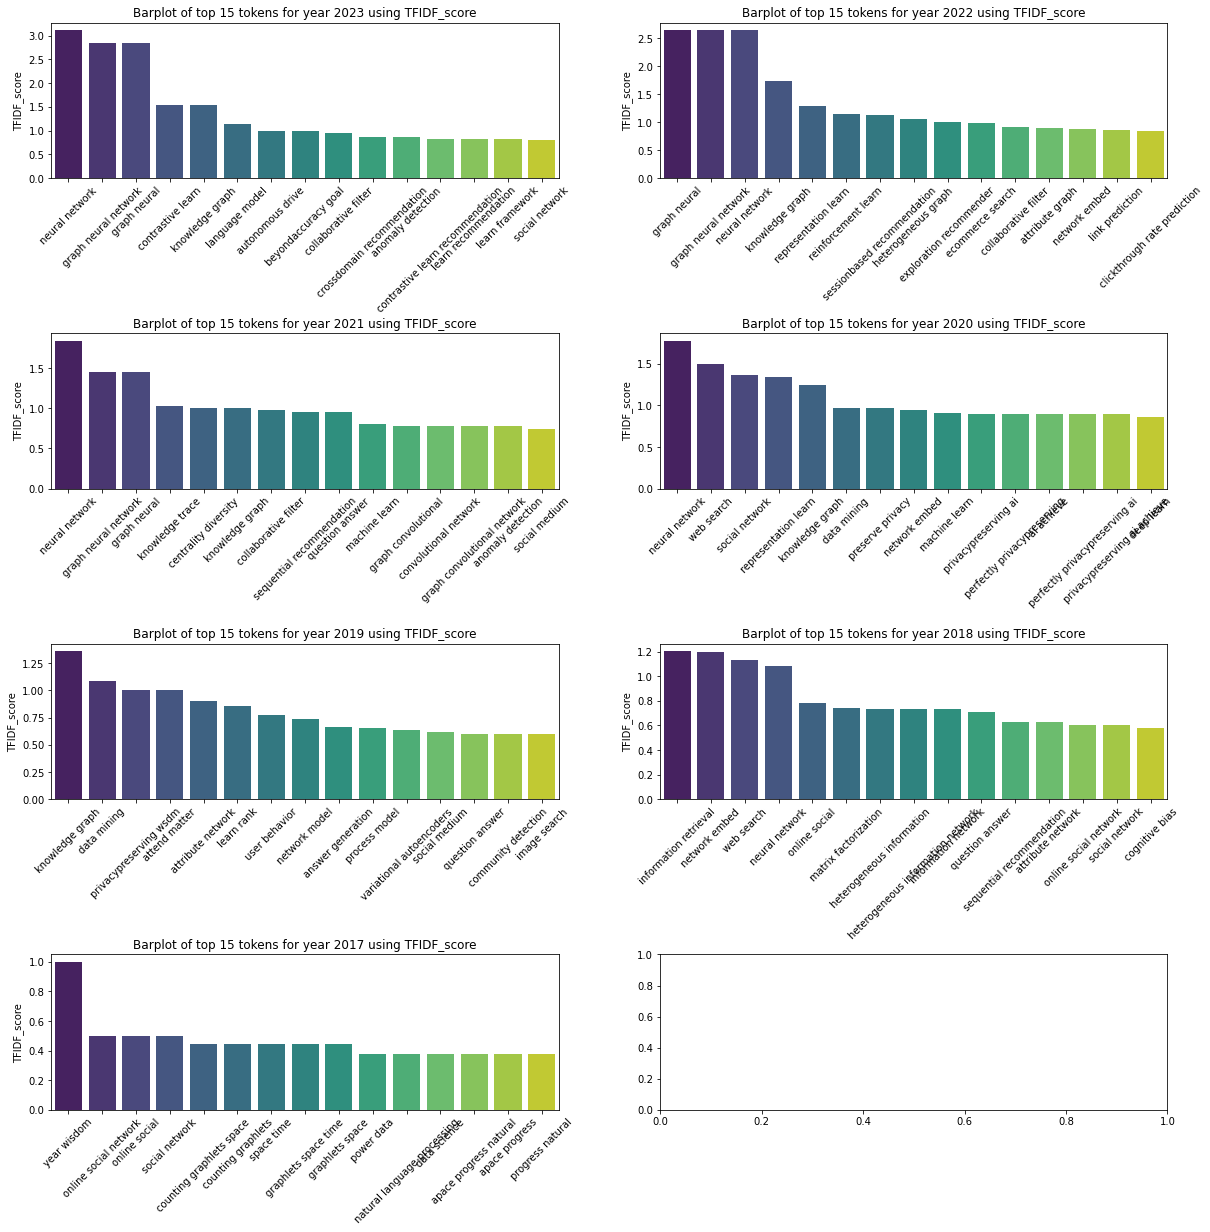

In [16]:
col_num = 2
doc = score_dict
top_n = 15
y = 'TFIDF_score'
x = 'Token'

plot_top_bar(doc, col_num, top_n, x, y)

In [17]:
def plot_wordcloud(doc, col_num, stopwords, max_words,  ngram_range, by, collocations = True):
    '''
    Wordcloud uses count frequency by default. 
    tfidf = True to load wordcloud base on tfidf scores
    tfidf = False to load wordcloud base on frequency count
    '''
    nrows, ncols = math.ceil(len(doc)/col_num), col_num
    fig, axs = plt.subplots(nrows, ncols, figsize=(10 * 2, 5 * nrows))

    yr_ls = list(doc.keys())
    for i in range(len(doc)):
        yr = yr_ls[i]
        text = ' '.join(doc[yr])
        
        tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, ngram_range=ngram_range)
        tfidf_matrix = tfidf_vectorizer.fit_transform(doc[yr])
        feature_names = tfidf_vectorizer.get_feature_names_out()
        word_tfidf_dict = dict(zip(feature_names, tfidf_matrix.sum(axis=0).A1))
        word_doc_freq_dict = dict(zip(feature_names, (tfidf_matrix > 0).sum(axis=0).A1))
        
        if by == 'doc_freq':
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  stopwords=stopwords, collocations = collocations, max_words=max_words)\
                                    .generate_from_frequencies(word_doc_freq_dict)
        if by == 'tfidf':
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  stopwords=stopwords, collocations = collocations, max_words=max_words)\
                                  .generate_from_frequencies(word_tfidf_dict)
              
        else:
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  stopwords=stopwords, collocations = collocations, max_words=max_words).generate(text)
            
        axs[i//ncols , i%ncols].imshow(wordcloud)
        axs[i//ncols , i%ncols].set_title(f"Word Cloud for Year {yr} using {by}")
        axs[i//ncols , i%ncols].axis("off")

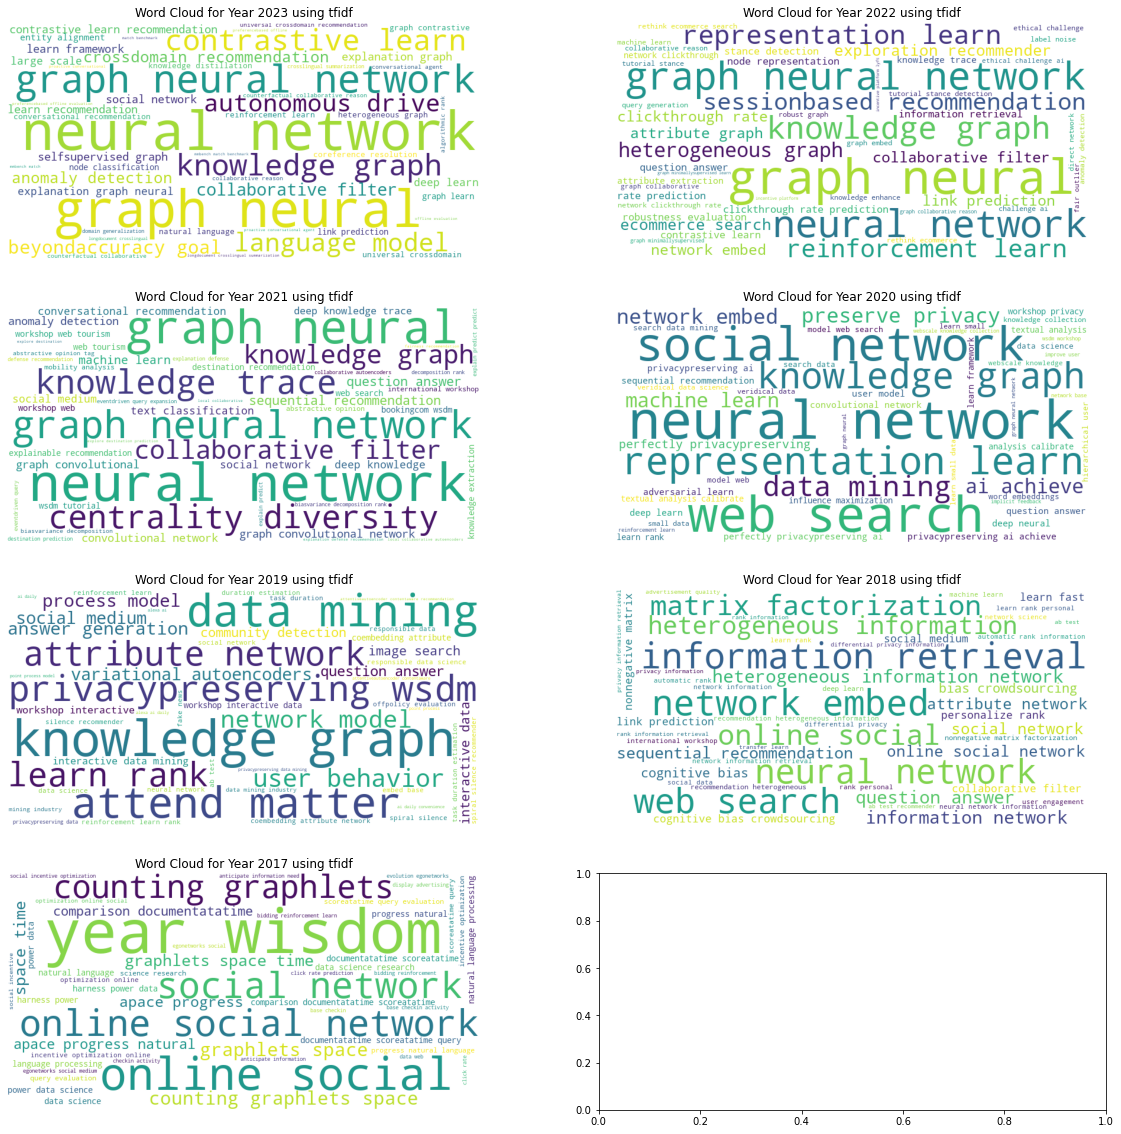

In [18]:
plot_wordcloud(pre_processed_doc, col_num=2, stopwords=manual_stopwords, 
               max_words=50, by = 'tfidf', ngram_range = ngram_range, collocations=False)

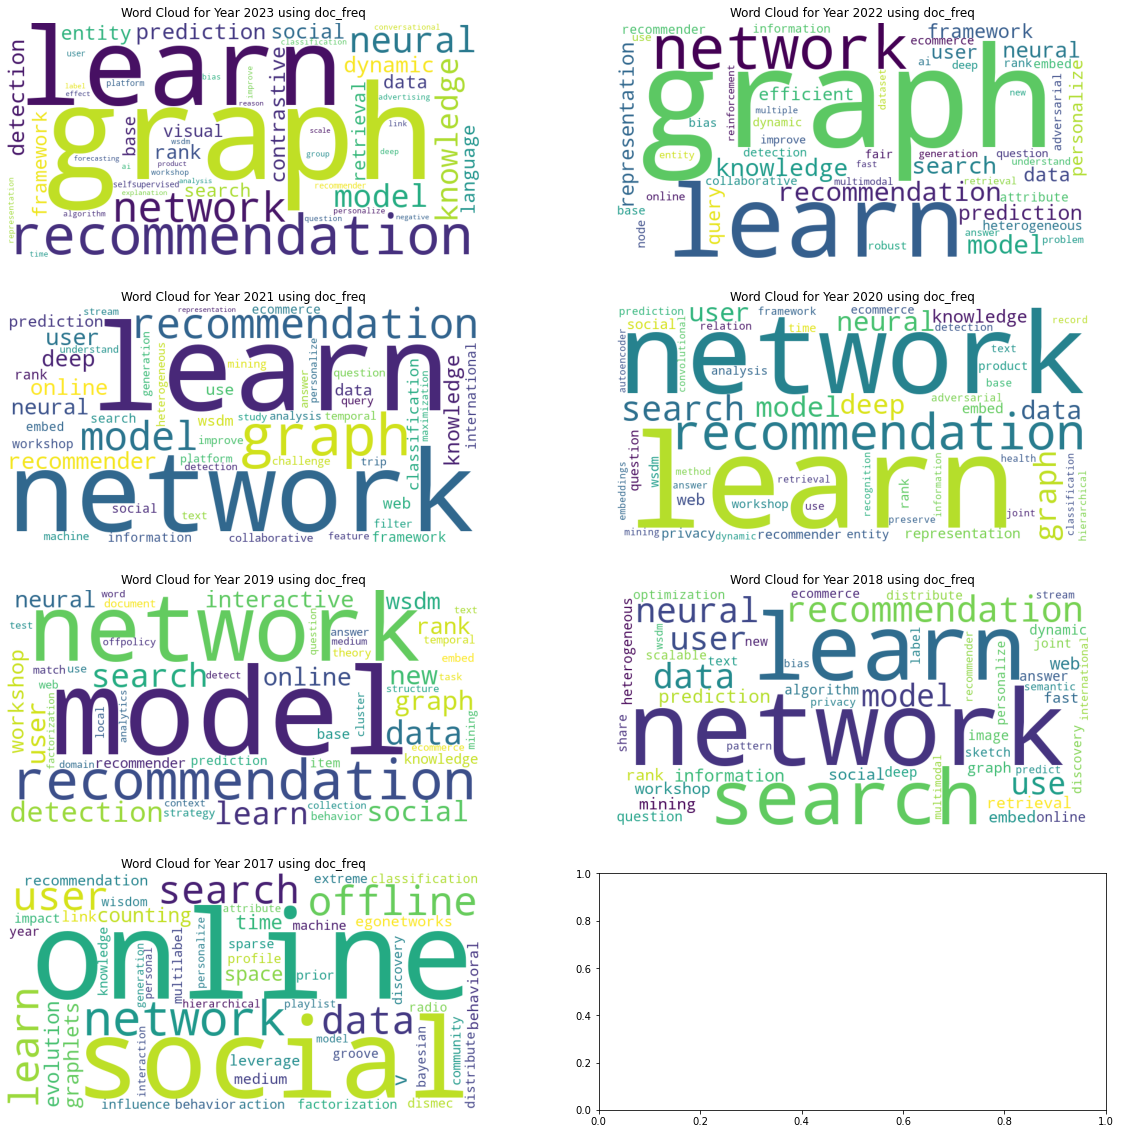

In [19]:
plot_wordcloud(pre_processed_doc, col_num=2, stopwords=manual_stopwords, 
               max_words=50, by = 'doc_freq', ngram_range = ngram_range, collocations=False)